In [7]:
import os
import cv2
import toml
import random
import wandb
from pycocotools.coco import COCO
import numpy as np
import torch
import torch.nn as nn
import skimage.io as io

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf

from src.utils import set_seed
from src.dataloader import COCODataset, Transformations
from src.model import DeepLabV3
from src.train_utils import train_model

In [8]:
DATA_PATH = "/home/glebk/Datasets/dataset_ocr" 


In [9]:
cfg = toml.load("/home/glebk/VSProjects/projects/tmp/src/cfg.toml")
cfg

{'img_size': [800, 600],
 'mask_size': [101, 76],
 'p_hflip': 0.5,
 'p_vflip': 0.5}

In [25]:
t_train = Transformations(cfg["img_size"], cfg["p_hflip"], cfg["p_vflip"], cfg["mask_size"])
t_test = Transformations(cfg["img_size"], 0, 0, cfg["mask_size"])


In [26]:
annot_file_train = os.path.join(DATA_PATH, "train_tf" + ".json")
coco_train = COCO(annot_file_train)
dataset_train = COCODataset(coco_train, DATA_PATH, t_train)

annot_file_test = os.path.join(DATA_PATH, "test_tf" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODataset(coco_test, DATA_PATH, t_test)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


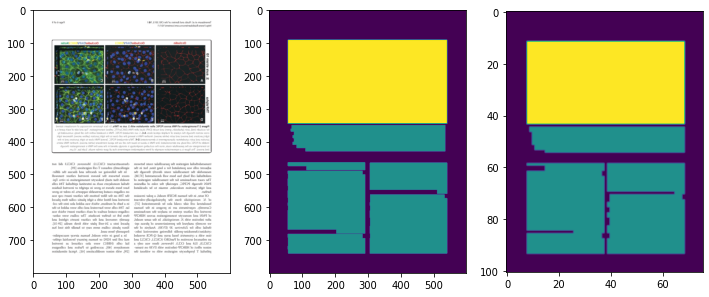

In [27]:
idx = np.random.randint(len(dataset_train))
img, mask, resized_mask = dataset_train[idx]

fig, ax = plt.subplots(1, 3, figsize=(12, 12), sharey=False)
ax[0].imshow(tf.to_pil_image(img))
ax[1].imshow(mask[0])
ax[2].imshow(resized_mask[0])

In [ ]:
if cfg["wandb_logging"]:
    # wandb.init(project="v_estimator_label", entity="glebk", group="filtration_model")
    wandb.init(project="v_estimator_2", entity="glebk")
    wandb.config = cfg


In [ ]:
train_loader = DataLoader(dataset_train, batch_size=cfg["bs"], shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=cfg["bs"], shuffle=False)

print(len(train_loader))
print(len(val_loader))


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DeepLabV3(
    n_classes=cfg["n_classes"],
    n_blocks=cfg["n_blocks"],
    atrous_rates=cfg["atrous_rates"],
    multi_grids=cfg["multi_grids"],
    output_stride=cfg["output_stride"],
)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"])
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=2500, gamma=0.95, verbose=True
# )

loss = nn.CrossEntropyLoss()

In [ ]:
train_model(model, train_loader, val_loader, device, optimizer, scheduler, cfg, loss_fn)
